# Lab 6

## Part A

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from scipy.stats import loguniform, uniform


1. Use sklearn.datasets.make moons(n samples=800, noise=0.1) to generate two interleaving
classes. Scatter-plot the data (colour by class).

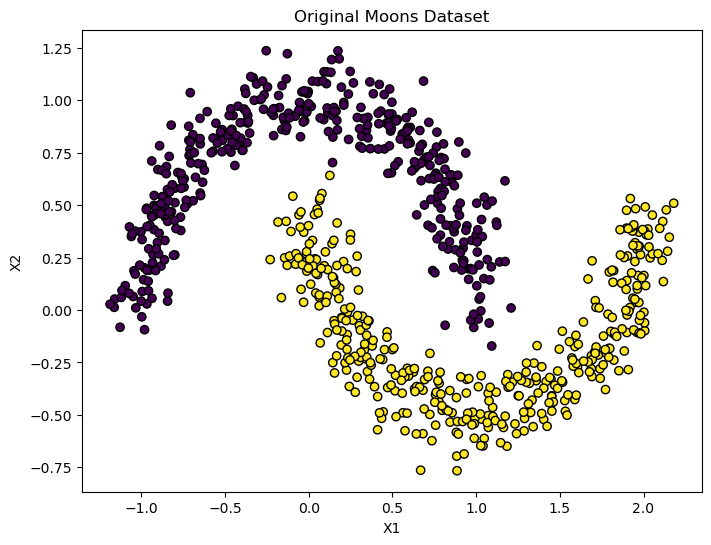

In [3]:
X, y = make_moons(n_samples=800, noise=0.1, random_state=42)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k')
plt.title('Original Moons Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

2. Randomly flip 10% of labels to inject mild label noise.

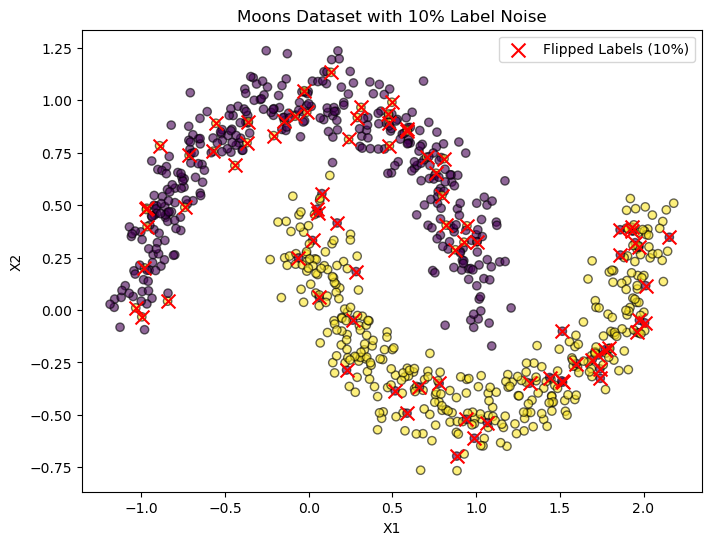

In [4]:
y_noisy = y.copy()
n_samples = len(y)
n_flips = int(n_samples * 0.10)

rs = np.random.RandomState(42) 
flip_i = rs.choice(n_samples, n_flips, replace=False)

y_noisy[flip_i] = 1 - y_noisy[flip_i]

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_noisy, cmap='viridis', edgecolors='k', alpha=0.6)
plt.scatter(X[flip_i, 0], X[flip_i, 1], c='r', marker='x', s=100, label='Flipped Labels (10%)')
plt.title('Moons Dataset with 10% Label Noise')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

3. Create a 70/30 stratified split and scale features with StandardScaler in a Pipeline

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_noisy, 
                                                      test_size=0.3, 
                                                      stratify=y_noisy, 
                                                      random_state=42)

base_mlp = MLPClassifier(random_state=42)
pipeline_template = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', base_mlp)
])

print("Create 70/30 stratified split:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nPipeline:\n{pipeline_template}")

Created 70/30 stratified split:
X_train shape: (560, 2)
X_test shape: (240, 2)
y_train shape: (560,)
y_test shape: (240,)

Defined pipeline template:
Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp', MLPClassifier(random_state=42))])


4. Classify the data using an MLPClassifier

In [7]:
seeds = [42, 1, 100, 2024, 77]
accuracies = []
aucs = []

for seed in seeds:
    X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X, y_noisy, 
                                                                    test_size=0.3, 
                                                                    stratify=y_noisy, 
                                                                    random_state=seed)
    
    mlp = MLPClassifier(max_iter=1000, 
                        solver='adam', 
                        early_stopping=True, 
                        validation_fraction=0.2, 
                        random_state=seed) 
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', mlp)
    ])
    
    pipeline.fit(X_train_rs, y_train_rs)
    
    y_pred = pipeline.predict(X_test_rs)
    y_proba = pipeline.predict_proba(X_test_rs)[:, 1]
    
    acc = accuracy_score(y_test_rs, y_pred)
    auc = roc_auc_score(y_test_rs, y_proba)
    
    accuracies.append(acc)
    aucs.append(auc)
    
    print(f"Seed {seed}: Accuracy={acc:.4f}, AUC={auc:.4f}")

print(f"\nMean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

Seed 42: Accuracy=0.8125, AUC=0.8837
Seed 1: Accuracy=0.7708, AUC=0.8771
Seed 100: Accuracy=0.7750, AUC=0.8649
Seed 2024: Accuracy=0.7458, AUC=0.7777
Seed 77: Accuracy=0.7958, AUC=0.8517

Mean Accuracy: 0.7800 ± 0.0227
Mean AUC:      0.8510 ± 0.0383


5. Train grids of architectures and plot decision boundaries

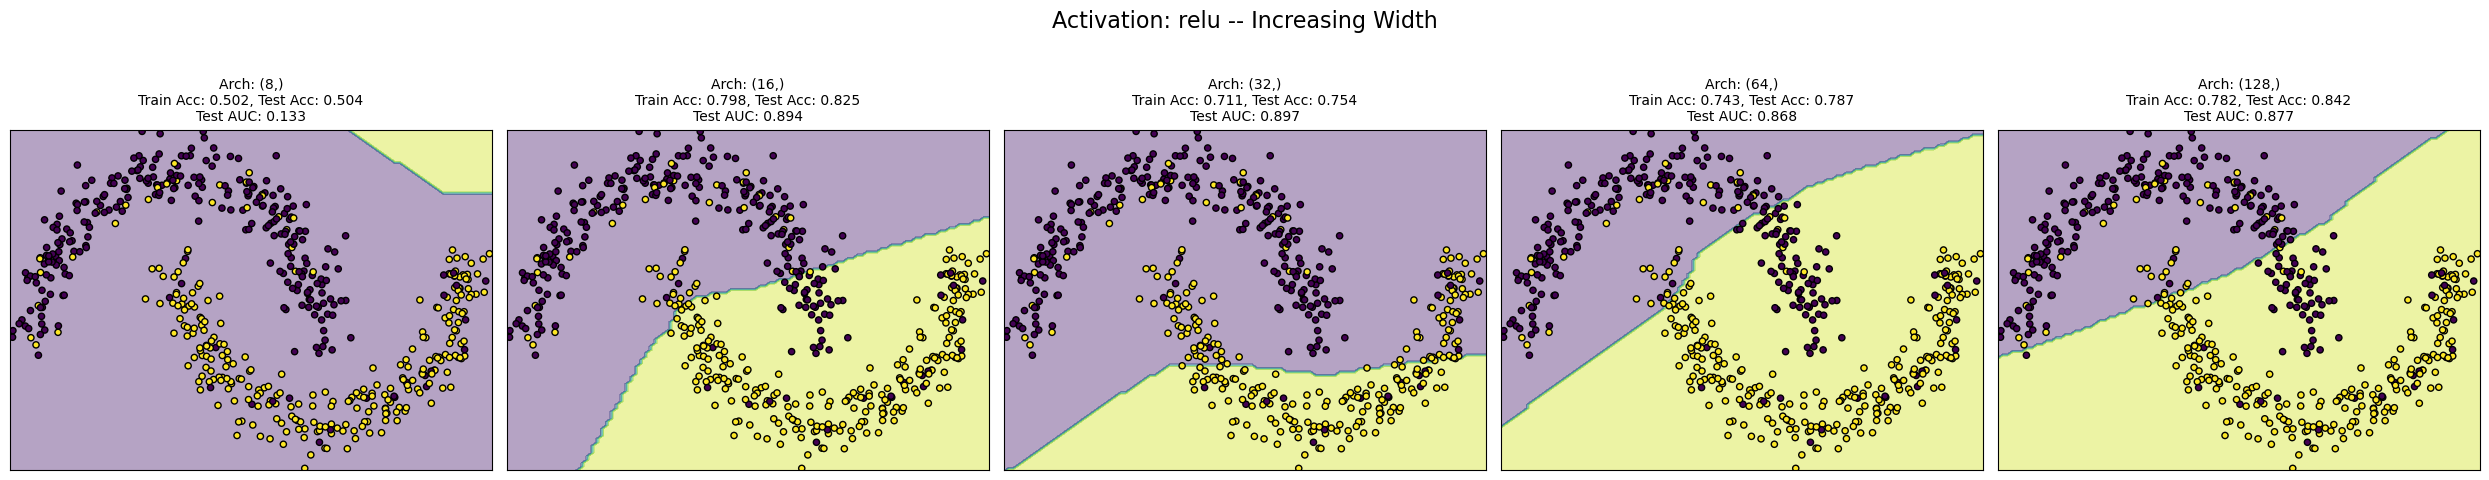

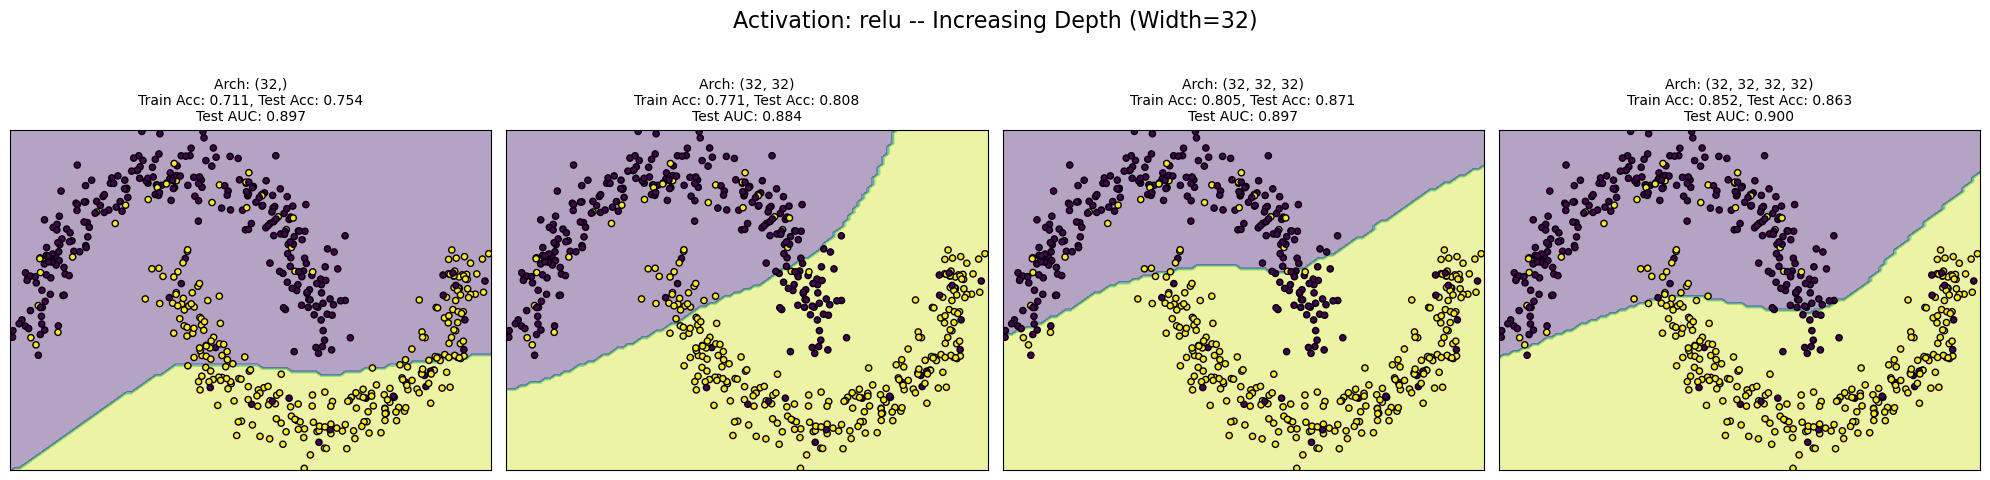

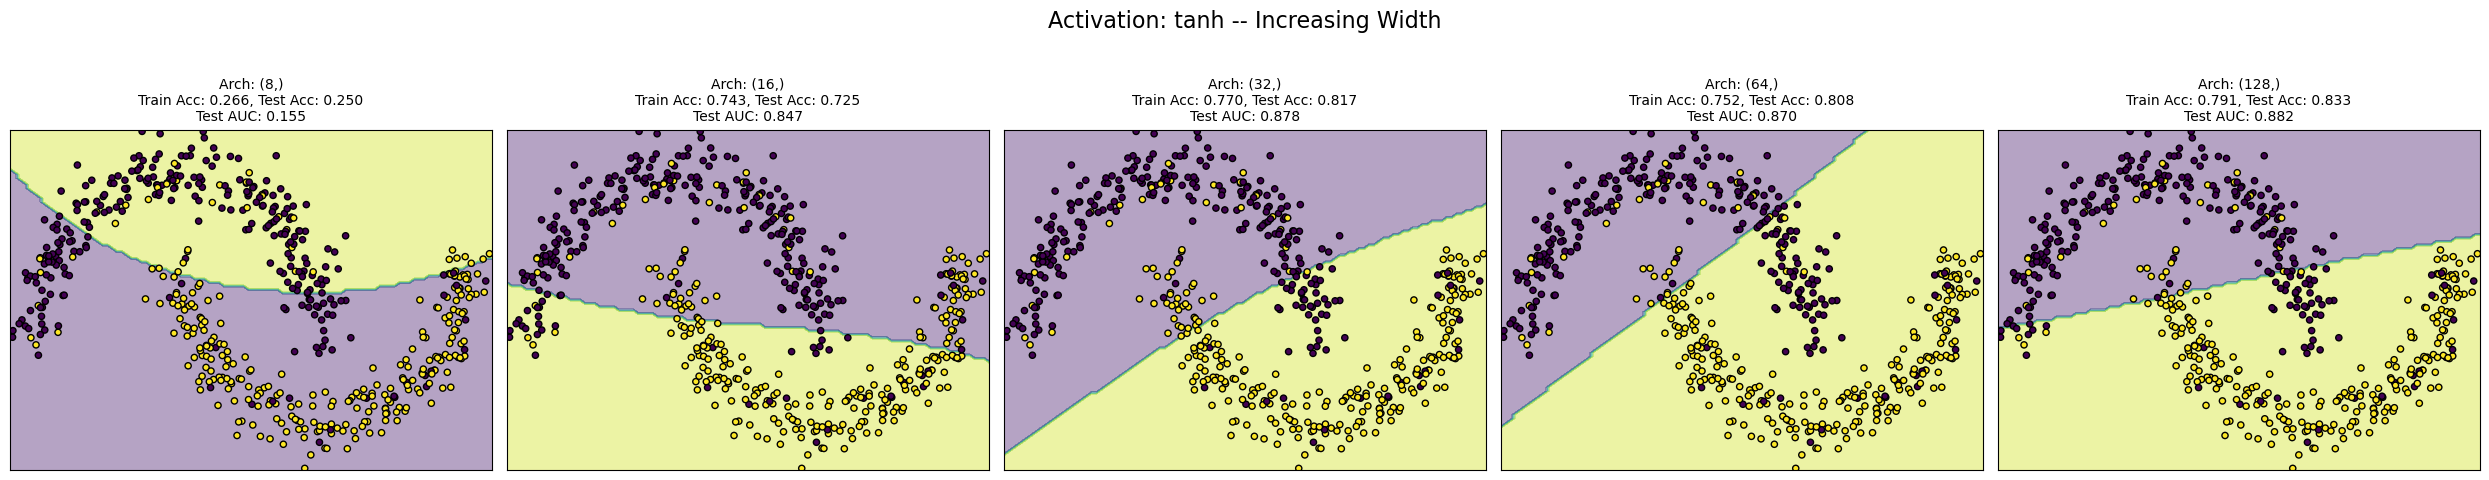

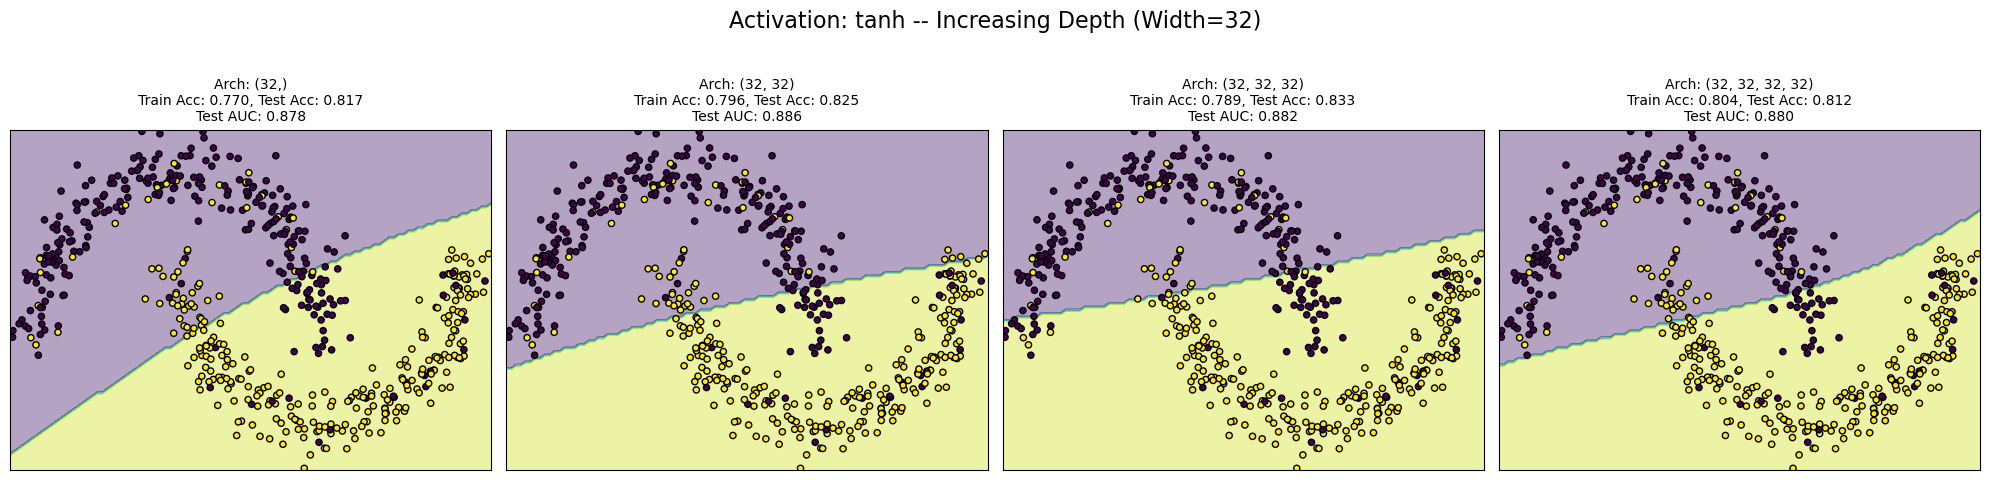

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

width_architectures = [(8,), (16,), (32,), (64,), (128,)]
depth_architectures = [(32,), (32, 32), (32, 32, 32), (32, 32, 32, 32)]
activations = ['relu', 'tanh']
common_params = {
    'max_iter': 1000, 
    'solver': 'adam', 
    'early_stopping': True, 
    'validation_fraction': 0.2, 
    'random_state': 42
}

for activation in activations:
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    fig.suptitle(f'Activation: {activation} -- Increasing Width', fontsize=16)
    
    for i, width in enumerate(width_architectures):
        ax = axes[i]
        clf = MLPClassifier(hidden_layer_sizes=width, activation=activation, **common_params)
        clf.fit(X_train_scaled, y_train)
        
        train_acc = clf.score(X_train_scaled, y_train)
        test_acc = clf.score(X_test_scaled, y_test)
        test_auc = roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:, 1])
        
        title = (f"Arch: {width}\n"
                 f"Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}\n"
                 f"Test AUC: {test_auc:.3f}")
        
        DecisionBoundaryDisplay.from_estimator(clf, X_train_scaled, ax=ax, response_method="predict", cmap='viridis', alpha=0.4, eps=0.02)
        ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='viridis', edgecolors='k', s=20)
        ax.set_title(title, fontsize=10)
        ax.set_xticks(())
        ax.set_yticks(())
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Activation: {activation} -- Increasing Depth (Width=32)', fontsize=16)
    
    for i, depth_arch in enumerate(depth_architectures):
        ax = axes[i]
        clf = MLPClassifier(hidden_layer_sizes=depth_arch, activation=activation, **common_params)
        clf.fit(X_train_scaled, y_train)
        
        train_acc = clf.score(X_train_scaled, y_train)
        test_acc = clf.score(X_test_scaled, y_test)
        test_auc = roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:, 1])
        
        title = (f"Arch: {depth_arch}\n"
                 f"Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}\n"
                 f"Test AUC: {test_auc:.3f}")
        
        DecisionBoundaryDisplay.from_estimator(clf, X_train_scaled, ax=ax, response_method="predict", cmap='viridis', alpha=0.4, eps=0.02)
        ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='viridis', edgecolors='k', s=20)
        ax.set_title(title, fontsize=10)
        ax.set_xticks(())
        ax.set_yticks(())
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


6. Increase label-noise rate to 20% and retrain with weight decay

In [10]:
y_noisy_20 = y.copy()
n_flips_20 = int(len(y) * 0.20)
rs_20 = np.random.RandomState(42)
flip_indices_20 = rs_20.choice(len(y), n_flips_20, replace=False)
y_noisy_20[flip_indices_20] = 1 - y_noisy_20[flip_indices_20]

X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X, y_noisy_20, 
                                                                test_size=0.3, 
                                                                stratify=y_noisy_20, 
                                                                random_state=42)

chosen_arch = (32, 32, 32, 32)
baseline_mlp = MLPClassifier(hidden_layer_sizes=chosen_arch, 
                             activation='relu', 
                             max_iter=1000, 
                             solver='adam', 
                             random_state=42, 
                             alpha=0.0, 
                             early_stopping=False) 

baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('mlp', baseline_mlp)
])

baseline_pipeline.fit(X_train_20, y_train_20)
y_proba_baseline = baseline_pipeline.predict_proba(X_test_20)[:, 1]
baseline_test_auc = roc_auc_score(y_test_20, y_proba_baseline)
print(f"Baseline Test AUC (20% noise, alpha=0.0): {baseline_test_auc:.4f}")

search_mlp = MLPClassifier(hidden_layer_sizes=chosen_arch, 
                           activation='relu', 
                           max_iter=1000, 
                           solver='adam', 
                           random_state=42, 
                           early_stopping=False) 

search_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('mlp', search_mlp)
])

param_grid = {'mlp__alpha': [1e-5, 1e-4, 1e-3]}

grid_search = GridSearchCV(search_pipeline, 
                           param_grid, 
                           cv=5, 
                           scoring='roc_auc', 
                           n_jobs=-1)

grid_search.fit(X_train_20, y_train_20)
best_alpha = grid_search.best_params_['mlp__alpha']
print(f"Best validation AUC (from CV): {grid_search.best_score_:.4f}")
print(f"Best alpha found by GridSearchCV: {best_alpha}")

best_regularized_pipeline = grid_search.best_estimator_
y_proba_regularized = best_regularized_pipeline.predict_proba(X_test_20)[:, 1]
regularized_test_auc = roc_auc_score(y_test_20, y_proba_regularized)
print(f"Regularized Test AUC (alpha={best_alpha}): {regularized_test_auc:.4f}")

change_in_auc = regularized_test_auc - baseline_test_auc
print(f"Change in Test AUC (Regularized - Baseline): {change_in_auc:+.4f}")

Baseline Test AUC (20% noise, alpha=0.0): 0.7851
Best validation AUC (from CV): 0.8159
Best alpha found by GridSearchCV: 0.0001
Regularized Test AUC (alpha=0.0001): 0.7901
Change in Test AUC (Regularized - Baseline): +0.0049


## Part B

1. Setup.

In [13]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Data loaded and split.
X_train shape: (14448, 8)
X_test shape: (6192, 8)


2. Baseline model.

In [17]:
baseline_mlp = MLPRegressor(hidden_layer_sizes=(128, 128),
                            activation='relu',
                            max_iter=1000,
                            random_state=42)

baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', baseline_mlp)
])

print("Training baseline model...")
baseline_pipeline.fit(X_train, y_train)
print("Training complete.")

y_pred = baseline_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Baseline Model Test Error ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")

Training baseline model...
Training complete.

--- Baseline Model Test Error ---
RMSE: 0.5171
MAE:  0.3491
R2:   0.7963


3. Regularisation & early stopping.

Training models with different alpha values...
Trained model with alpha=1e-06
Trained model with alpha=0.0001
Trained model with alpha=0.01


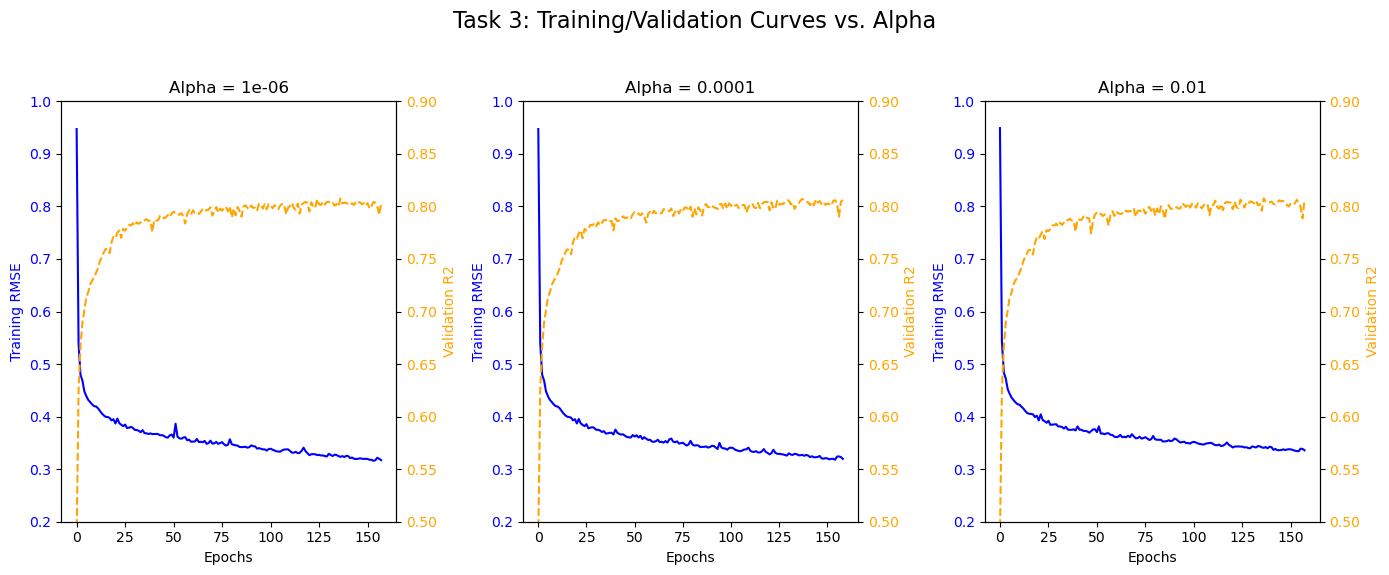

In [18]:
alphas = [1e-6, 1e-4, 1e-2]
results = {}

print("Training models with different alpha values...")
plt.figure(figsize=(14, 6))

for alpha in alphas:
    reg_mlp = MLPRegressor(hidden_layer_sizes=(128, 128),
                           activation='relu',
                           max_iter=1000,
                           random_state=42,
                           alpha=alpha,  
                           early_stopping=True,
                           validation_fraction=0.2,
                           n_iter_no_change=20)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', reg_mlp)
    ])
    
    pipeline.fit(X_train, y_train)
    
    results[alpha] = {
        'train_rmse': np.sqrt(pipeline.named_steps['mlp'].loss_curve_),
        'valid_r2': pipeline.named_steps['mlp'].validation_scores_
    }
    print(f"Trained model with alpha={alpha}")

for alpha in alphas:
    ax1 = plt.subplot(1, len(alphas), alphas.index(alpha) + 1)
    
    train_rmse = results[alpha]['train_rmse']
    ax1.plot(train_rmse, label=f'Train RMSE', color='blue')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training RMSE', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(0.2, 1.0)

    ax2 = ax1.twinx()
    valid_r2 = results[alpha]['valid_r2']
    ax2.plot(valid_r2, label=f'Valid R2', color='orange', linestyle='--')
    ax2.set_ylabel('Validation R2', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim(0.5, 0.9) 

    ax1.set_title(f'Alpha = {alpha}')
    
plt.suptitle('Task 3: Training/Validation Curves vs. Alpha', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

4. Learning-rate schedule. 

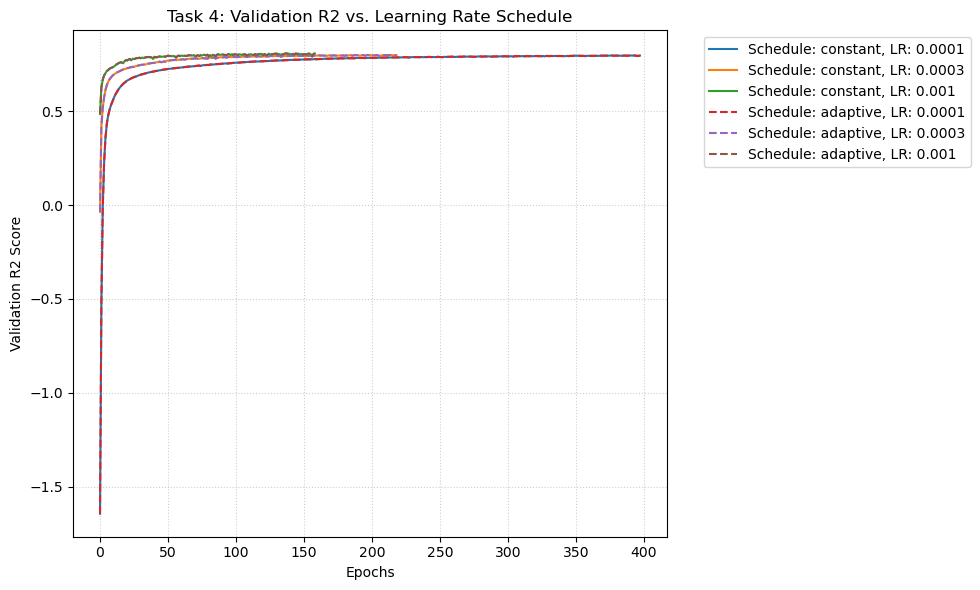

In [19]:
schedules = ['constant', 'adaptive']
learning_rates = [1e-4, 3e-4, 1e-3]
best_alpha_from_task3 = 1e-4 

plt.figure(figsize=(10, 6))

for schedule in schedules:
    for lr_init in learning_rates:
        # Define the MLP
        lr_mlp = MLPRegressor(hidden_layer_sizes=(128, 128),
                              activation='relu',
                              max_iter=1000,
                              random_state=42,
                              alpha=best_alpha_from_task3,
                              learning_rate=schedule,
                              learning_rate_init=lr_init,
                              early_stopping=True,
                              validation_fraction=0.2,
                              n_iter_no_change=20)
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('mlp', lr_mlp)
        ])
        
        pipeline.fit(X_train, y_train)
        
        valid_r2 = pipeline.named_steps['mlp'].validation_scores_
        label = f"Schedule: {schedule}, LR: {lr_init}"
        linestyle = '--' if schedule == 'adaptive' else '-'
        plt.plot(valid_r2, label=label, linestyle=linestyle)

plt.title('Task 4: Validation R2 vs. Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Validation R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

5. Hyperparameter optimisation (RandomizedSearchCV). 

In [20]:
search_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(max_iter=1000, early_stopping=True, random_state=42))
])


param_grid_adam = {
    'mlp__solver': ['adam'],
    'mlp__hidden_layer_sizes': [(64, 64), (128, 128), (256, 256), (128, 64)],
    'mlp__alpha': loguniform(1e-6, 1e-2),
    'mlp__learning_rate_init': loguniform(1e-4, 1e-2),
    'mlp__batch_size': [32, 64, 128]
}

param_grid_sgd = {
    'mlp__solver': ['sgd'],
    'mlp__hidden_layer_sizes': [(64, 64), (128, 128), (256, 256), (128, 64)],
    'mlp__alpha': loguniform(1e-6, 1e-2),
    'mlp__learning_rate_init': loguniform(1e-4, 1e-2),
    'mlp__batch_size': [32, 64, 128],
    'mlp__momentum': uniform(0.6, 0.35) 
}

n_iterations = 20 

random_search = RandomizedSearchCV(
    estimator=search_pipeline,
    param_distributions=[param_grid_adam, param_grid_sgd],
    n_iter=n_iterations,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1 
)

print(f"Running RandomizedSearchCV (n_iter={n_iterations}, cv=5)...")
random_search.fit(X_train, y_train)
print("Search complete.")

best_cv_rmse = -random_search.best_score_
print("\n--- Best Config (from CV) ---")
print(f"Best Mean CV RMSE: {best_cv_rmse:.4f}")
print("Best Parameters:")
print(random_search.best_params_)

print("\n--- Best Model Test Error ---")
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
best_mae = mean_absolute_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)

print(f"Test RMSE: {best_rmse:.4f}")
print(f"Test MAE:  {best_mae:.4f}")
print(f"Test R2:   {best_r2:.4f}")


Running RandomizedSearchCV (n_iter=20, cv=5)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/jrx/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jrx/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Search complete.

--- Best Config (from CV) ---
Best Mean CV RMSE: 0.5283
Best Parameters:
{'mlp__alpha': np.float64(0.0015352246941973493), 'mlp__batch_size': 128, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': np.float64(0.0036256176345762273), 'mlp__solver': 'adam'}

--- Best Model Test Error ---
Test RMSE: 0.5104
Test MAE:  0.3389
Test R2:   0.8015
